# MultiCamera Paper Results Generation and Plotting

In [382]:
import matplotlib.pyplot as plt
%matplotlib notebook
from collections import defaultdict
import os
import json
import pandas as pd
import numpy as np

In [383]:
aspect = 1.3
height = 2.5
# params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (15, 5),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}

params = {'axes.labelsize': 'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

In [328]:
import sys
sys.path.append("../..") # Adds higher directory to python modules path.

from utilitysimv4 import Camera, InferenceJob, TrainingJob, MultiPeriodSimulator, fair_naive_scheduler, fair_dumb_scheduler, fair_sco_scheduler, fair_random_scheduler, inference_only_scheduler, single_camera_naive, get_optimus_fn, thief_sco_scheduler, single_camera_optimizer, get_tanh_fn, get_linear_fn, get_infer_profile, get_tanh_fn, simulator, thief_scheduler, fair_scheduler

In [329]:
# !!!!!!! CONFIGURE THESE PARAMS !!!!!!!!
dataset = 'waymo' #'cityscapes'
pred_mode = 'datadist'# 'datadist'

In [330]:
PROFILE_DIR = '/home/romilb/research/msr/results/profiling/new_profiling/{}/meta/profiles'.format(dataset)
INFERENCE_PROFILE_PATH = '../real_inference_profiles.csv'
INFERENCE_MAX_DEFAULT = 0.25
PLOT_PATH = './camready_plots/'
os.makedirs(PLOT_PATH, exist_ok=True)

In [331]:
l=os.listdir(PROFILE_DIR)
cities=[x.split('.')[0] for x in l]
print(cities)

[]


In [504]:
num_cams = 5
dataset='cityscapes'
all_data = pd.read_csv('{}_zxxia/citywise_results_{}_{}cam_2.0delay_opt.csv'.format(dataset, dataset, num_cams))

In [505]:
x=all_data[(all_data['sched']=='thief') & (all_data['res']==4) & (all_data['period']==100) & (all_data['use_oracle']==True)]# & (citywise_data['city']=="phx-21-40")]

In [506]:
tasks = [t for t in x.mean().keys() if "task" in t]

# Plotting

In [507]:
styles = ['^-', 'v-', 'o-']

In [508]:
PERIOD=200
USE_ORACLE_INFO = True
d = all_data
d = d[d['use_oracle'] == USE_ORACLE_INFO]
d = d[d['period'] == PERIOD]
scheds = ['inference_only', 'fair_dumb','thief']
labels = ["No-retrain", "Fair Scheduler", "Ekya"]

In [509]:
# Group data and create overall_mean col
plot_data = d.groupby(['sched', 'res', 'city']).mean()
tasks = [x for x in plot_data.columns if "task_" in x]
plot_data['overall_mean'] = plot_data[tasks].mean(axis=1)
mean_acc_data = plot_data['overall_mean'].mean(level=['sched', 'res']).unstack(level=0)

In [510]:
mean_acc_data

sched,fair_dumb,fair_naive,fair_random,fair_sco,inference_only,thief
res,,,,,,
1,0.497950,0.515372,0.598887,0.553783,0.651760,0.638874
2,0.675454,0.697539,0.741089,0.724542,0.689692,0.759985
4,0.720215,0.725890,0.754786,0.758580,0.689692,0.784100
8,0.737898,0.738013,0.768134,0.769499,0.689692,0.799186


In [511]:
from scipy import interpolate

In [512]:
def get_resource_savings(sched, gpus):
    xvals = mean_acc_data[sched].values
    yvals = mean_acc_data[sched].index.values
    pred_val = mean_acc_data['thief'][gpus]
    #f = interpolate.interp1d(xvals, yvals, fill_value='extrapolate')
    f = lambda x: np.interp(x, xvals, yvals, right=0)
    return f(pred_val)/gpus

<IPython.core.display.Javascript object>


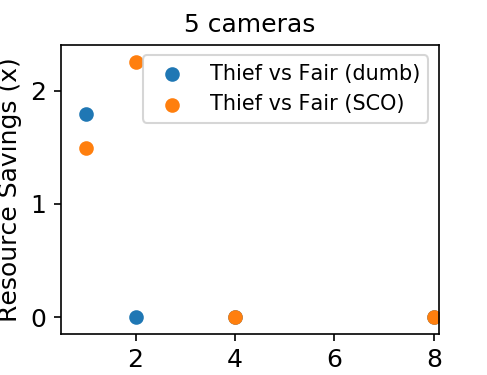

Fair Dumb: [1.7939218541780064, 0.0, 0.0, 0.0]
Fair SCO: [1.4983095919462603, 2.2573746413592457, 0.0, 0.0]


In [513]:
fig = plt.figure(figsize=[aspect*height, height])
ax = plt.gca()
gpus_range = [1,2,4,8]
fairdumb_savings = [get_resource_savings('fair_dumb', g) for g in gpus_range]
fairsco_savings = [get_resource_savings('fair_sco', g) for g in gpus_range]
print("Fair Dumb: {}".format(fairdumb_savings))
print("Fair SCO: {}".format(fairsco_savings))
ax.scatter(gpus_range, fairdumb_savings, label='Thief vs Fair (dumb)')
ax.scatter(gpus_range, fairsco_savings, label='Thief vs Fair (SCO)')
plt.legend()
ax.set_ylabel('Resource Savings (x)')
ax.set_xlabel('GPUs Provisioned')
ax.set_title('{} cameras'.format(num_cams))
ax.set_xlim([0.5,8.1])
plt.savefig(os.path.join(PLOT_PATH, "ressavings_{}_cities_{}.pdf".format(num_cams,dataset)), bbox_inches='tight')

# Plot Acc vs Resources Provisioned

In [323]:
mean_acc_data = plot_data['overall_mean'].mean(level=['sched', 'res']).unstack(level=0)
std_acc_data = plot_data['overall_mean'].std(level=['sched', 'res']).unstack(level=0)

In [324]:
mean_acc_data

sched,fair_dumb,fair_naive,fair_random,fair_sco,inference_only,thief
res,,,,,,
1,0.834175,0.882202,0.881867,0.889291,0.797162,0.897739
2,0.873027,0.890408,0.889287,0.901560,0.797162,0.906916
4,0.896423,0.896423,0.892880,0.907891,0.797162,0.912294
8,0.908088,0.908088,0.894800,0.912365,0.797162,0.914788


In [315]:
mean_acc_data['thief'] - mean_acc_data[['fair_dumb','inference_only']].max(axis=1)

res
1    0.064052
2    0.034826
4    0.021964
8    0.010867
dtype: float64

In [325]:
mean_acc_data['thief'] - mean_acc_data[['fair_dumb','inference_only']].max(axis=1)

res
1    0.063564
2    0.033890
4    0.015871
8    0.006700
dtype: float64

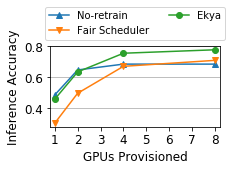

In [266]:
fig = plt.figure(figsize=[aspect*height, height])
ax = plt.gca()
ax = mean_acc_data.plot(y=scheds, kind='line', style=styles, ax=ax,
                       label = labels)#, yerr=std_acc_data)

lgd = ax.legend(loc="lower center", bbox_to_anchor=(0,1.02,1,0.2), ncol=2)
ax.set_ylabel('Inference Accuracy')
ax.set_xlabel('GPUs Provisioned')

x_tick_range = range(1,9)
ax.set_xticks(x_tick_range)
ax.set_xticklabels(["{:d}".format(x) for x in x_tick_range])
ax.set_xlim([0.8, 8.2])

#y_tick_range = np.arange(0.1,0.9,0.1)
#ax.set_yticks(y_tick_range)
#ax.set_yticklabels(["{:.1f}".format(x) for x in y_tick_range])
plt.tight_layout()
ax.yaxis.grid(True)
plt.savefig(os.path.join(PLOT_PATH, "{}_cities_{}.pdf".format(num_cams,dataset)), bbox_inches='tight')

In [160]:
std_acc_data

sched,fair_dumb,fair_naive,fair_random,fair_sco,inference_only,thief
res,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN


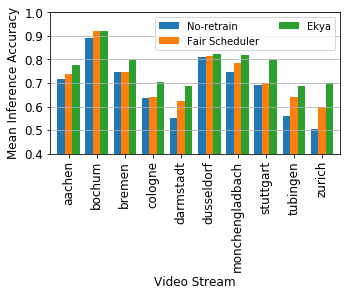

In [21]:
NUM_RES = 8
per_city_data = plot_data.query('res == {}'.format(NUM_RES))[tasks].mean(axis=1).mean(level=['sched', 'city']).unstack(level=0)
std_acc_data = plot_data.query('res == {}'.format(NUM_RES))[tasks].std(axis=1).mean(level=['sched', 'city']).unstack(level=0)

fac = 1.6
fig = plt.figure(figsize=[aspect*height*fac, height*fac*0.65])
ax = plt.gca()
ax = per_city_data.plot(y=scheds, kind='bar', ax=ax, width=0.8, yerr=std_acc_data,
                       label = labels)
ax.set_ylim([0.4,1])
ax.set_yticks(np.arange(0.4,1.01, 0.1))
ax.set_ylabel('Mean Inference Accuracy')
#ax.set_xticklabels(["V{}".format(i) for i in range(1, len(ax.get_xticklabels())+1)], rotation=45, ha='center')
ax.set_xlabel('Video Stream')

#lgd = ax.legend(loc="lower center", bbox_to_anchor=(0,1.02,1,0.2), ncol=2, prop={'size': 'medium'})

lgd = ax.legend(ncol=2, prop={'size': 'medium'})

#plt.tight_layout()
ax.yaxis.grid(True)
#plt.savefig(os.path.join(PLOT_PATH, "multicam_individual_stream_acc_{}.pdf".format(dataset)), bbox_inches='tight')

# Time Series Plot

In [20]:
NUM_RES = 4
city = 'zurich' if dataset == 'cityscapes' else 'phx-41-60_1'
timeseries_data = plot_data.query('res == {}'.format(NUM_RES)).query('city == \'{}\''.format(city))

In [21]:
d = timeseries_data[tasks].mean(level=['sched']).transpose()
d = d[scheds]

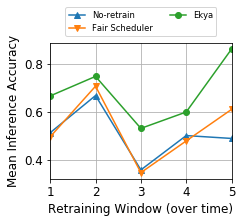

In [22]:
fig = plt.figure(figsize=[aspect*height, height])
ax = plt.gca()

ax = d.plot(y=scheds, style = styles, ax=ax,
            label = labels)
lgd = ax.legend(loc="lower center", bbox_to_anchor=(0,1.02,1,0.2), ncol=2, prop={'size': 'small'})
ax.set_ylabel('Mean Inference Accuracy')
ax.set_xlabel('Retraining Window (over time)')
ax.set_xticks(range(0,5))
ax.set_xticklabels(range(1,6))
ax.grid(True)
plt.savefig(os.path.join(PLOT_PATH, "multicam_taskwise_acc_{}_{}_{}.pdf".format(city, NUM_RES, dataset)), bbox_inches='tight')

# Cost plot

In [34]:
mean_acc_data = plot_data['overall_mean'].mean(level=['sched', 'res', 'city']).unstack(level='res')
#mean_acc_data = mean_acc_data.reorder_levels(['city', 'sched'])

In [37]:
cost_data = mean_acc_data.groupby(['city','sched']).mean()

In [51]:
cost_data.index

MultiIndex(levels=[['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'monchengladbach', 'stuttgart', 'tubingen', 'zurich'], ['fair_dumb', 'fair_sco', 'inference_only', 'thief']],
           codes=[[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9], [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]],
           names=['city', 'sched'])

In [56]:
cost_data[[4,8]]

res                                    4         8
city            sched                             
aachen          fair_dumb       0.697024  0.736173
                fair_sco        0.754116  0.782585
                inference_only  0.715068  0.715068
                thief           0.766142  0.775399
bochum          fair_dumb       0.884134  0.918698
                fair_sco        0.909117  0.921592
                inference_only  0.892308  0.892308
                thief           0.915625  0.922758
bremen          fair_dumb       0.722770  0.747573
                fair_sco        0.760945  0.784206
                inference_only  0.747573  0.747573
                thief           0.781691  0.799095
cologne         fair_dumb       0.613628  0.641077
                fair_sco        0.646182  0.669072
                inference_only  0.635000  0.635000
                thief           0.685731  0.702960
darmstadt       fair_dumb       0.561269  0.624780
                fair_sco        0.606337  0.634818
                inference_only  0.550000  0.550000
                thief           0.669070  0.687533
dusseldorf      fair_dumb       0.785018  0.816071
                fair_sco        0.813381  0.832084
                inference_only  0.810405  0.810405
                thief           0.810607  0.823666
monchengladbach fair_dumb       0.741947  0.782970
                fair_sco        0.762917  0.790614
                inference_only  0.748000  0.748000
                thief           0.809738  0.817377
stuttgart       fair_dumb       0.668916  0.700205
                fair_sco        0.745092  0.758162
                inference_only  0.690244  0.690244
                thief           0.768987  0.796608
tubingen        fair_dumb       0.550805  0.641409
                fair_sco        0.636038  0.651385
                inference_only  0.559494  0.559494
                thief           0.678778  0.688613
zurich          fair_dumb       0.526615  0.598821
                fair_sco        0.602078  0.669213
                inference_only  0.504762  0.504762
                thief           0.679929  0.698331

# Number of streams plot

In [76]:
all_data = pd.read_csv('data_eval_multicam_varyingcam_all_data_{}_{}.csv'.format(dataset, pred_mode))

In [77]:
all_data

,time,task_1,task_2,task_3,task_4,task_5,city,res,period,use_oracle,sched,num_cams
0,0,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
1,1,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
2,2,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
3,3,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
4,4,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
5,5,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
6,6,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
7,7,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
8,8,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1
9,9,0.511905,0.666667,0.357143,0.5,0.488095,zurich_0,1,100,False,fair_dumb,1


In [78]:
PERIOD=100
USE_ORACLE_INFO = False
d = all_data
d = d[d['use_oracle'] == USE_ORACLE_INFO]
d = d[d['period'] == PERIOD]
scheds = ['inference_only', 'fair_dumb','thief']
labels = ["No-retrain", "Fair Scheduler", "Ekya"]

In [79]:
# Group data and create overall_mean col
plot_data = d.groupby(['sched', 'res', 'num_cams']).mean()
tasks = [x for x in plot_data.columns if "task_" in x]
plot_data['overall_mean'] = plot_data[tasks].mean(axis=1)

In [80]:
plot_data

time    task_1    task_2    task_3    task_4  \
sched          res num_cams                                                 
fair_dumb      1   1           50  0.647218  0.732673  0.485856  0.500000   
                   2           50  0.614215  0.679632  0.446252  0.500000   
                   5           50  0.370127  0.473336  0.253573  0.355002   
                   8           50  0.307144  0.400002  0.214287  0.300001   
                   10          50  0.225246  0.293344  0.157149  0.220008   
               2   1           50  0.663720  0.759783  0.505658  0.500000   
                   2           50  0.647218  0.732673  0.485856  0.500000   
                   5           50  0.583685  0.630001  0.414690  0.472501   
                   8           50  0.461409  0.520002  0.292000  0.390002   
                   10          50  0.370127  0.473336  0.253573  0.355002   
               4   1           50  0.671971  0.772749  0.515559  0.500000   
                   2           50  0.663720  0.759783  0.505658  0.500000   
                   5           50  0.638967  0.719708  0.475955  0.500000   
                   8           50  0.614215  0.679632  0.446252  0.500000   
                   10          50  0.583685  0.630001  0.414690  0.472501   
               8   1           50  0.675271  0.779821  0.520509  0.554455   
                   2           50  0.671971  0.772749  0.515559  0.500000   
                   5           50  0.658769  0.752711  0.500707  0.500000   
                   8           50  0.647218  0.732673  0.485856  0.500000   
                   10          50  0.638967  0.719708  0.475955  0.500000   
fair_sco       1   1           50  0.511905  0.740924  0.462164  0.594413   
                   2           50  0.511905  0.731848  0.460042  0.580622   
                   5           50  0.471840  0.576479  0.417502  0.435891   
                   8           50  0.385603  0.418814  0.334966  0.300001   
                   10          50  0.337455  0.293344  0.290830  0.220008   
               2   1           50  0.511905  0.745875  0.463225  0.595474   
                   2           50  0.511905  0.740924  0.462164  0.583805   
                   5           50  0.510511  0.716325  0.457756  0.533492   
                   8           50  0.502985  0.645892  0.446726  0.416628   
                   10          50  0.471840  0.576479  0.417502  0.355002   
...                           ...       ...       ...       ...       ...   
inference_only 4   1           50  0.511905  0.666667  0.357143  0.500000   
                   2           50  0.511905  0.666667  0.357143  0.500000   
                   5           50  0.511905  0.666667  0.357143  0.500000   
                   8           50  0.511905  0.666667  0.357143  0.500000   
                   10          50  0.511905  0.666667  0.357143  0.500000   
               8   1           50  0.511905  0.666667  0.357143  0.500000   
                   2           50  0.511905  0.666667  0.357143  0.500000   
                   5           50  0.511905  0.666667  0.357143  0.500000   
                   8           50  0.511905  0.666667  0.357143  0.500000   
                   10          50  0.511905  0.666667  0.357143  0.500000   
thief          1   1           50  0.511905  0.744224  0.463225  0.592291   
                   2           50  0.511068  0.731848  0.459427  0.581153   
                   5           50  0.471996  0.624001  0.417502  0.454074   
                   8           50  0.385603  0.521430  0.334613  0.377229   
                   10          50  0.337455  0.453837  0.293288  0.340378   
               2   1           50  0.511905  0.747525  0.464286  0.600778   
                   2           50  0.511905  0.744224  0.463225  0.591231   
                   5           50  0.510511  0.721113  0.458266  0.569553   
                   8           50  0.504226  0.659817  0.448365  0.503858   
                   10    

In [126]:
mean_acc_data = plot_data['overall_mean'].mean(level=['sched', 'res', 'num_cams']).unstack(level=0)

In [127]:
#mean_acc_data.values[-5][0] = 0.632412

## Have a hypothetical max accuracy and plot the remainder based off fractions of that

In [128]:
MAX_ACC = 0.7

In [129]:
t = mean_acc_data['thief'].unstack(0) > 0.62

In [130]:
t

res,1,2,4,8
num_cams,,,,
1,True,True,True,True
2,True,True,True,True
5,False,False,True,True
8,False,False,True,True
10,False,False,False,True


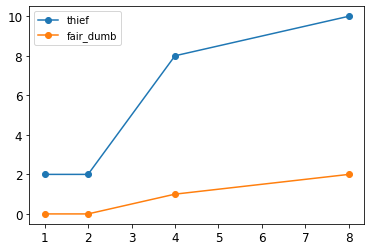

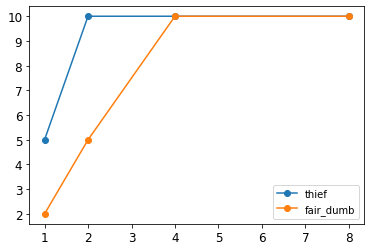

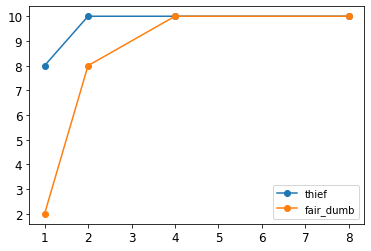

In [131]:
for thresh in [0.62, 0.5, 0.4]:
    plt.figure()
    for sched in ['thief', 'fair_dumb']:
        t = mean_acc_data[sched].unstack(0) > thresh
        plot_data_x = []
        plot_data_y = []
        for res in t.columns:
            cams_list = t.index[t[res] == True]
            num_cams_supported = max(cams_list) if len(cams_list) else 0
            plot_data_x.append(num_cams_supported)
            plot_data_y.append(res)
        plt.plot(plot_data_y, plot_data_x, label=sched, marker='o')
        plt.legend()

In [132]:
mean_acc_data['fair_dumb'].unstack(0) > 0.62

res,1,2,4,8
num_cams,,,,
1,False,False,True,True
2,False,False,False,True
5,False,False,False,False
8,False,False,False,False
10,False,False,False,False


In [133]:
mean_acc_data

sched         fair_dumb  fair_sco  inference_only     thief
res num_cams                                               
1   1          0.570769  0.632673        0.504762  0.633876
    2          0.545639  0.623904        0.504762  0.625032
    5          0.359717  0.522568        0.477001  0.525112
    8          0.302858  0.394931        0.393716  0.430829
    10         0.222103  0.313830        0.358383  0.369607
2   1          0.587223  0.635596        0.504762  0.637954
    2          0.570769  0.630552        0.504762  0.634041
    5          0.512426  0.608449        0.504762  0.617389
    8          0.408826  0.558471        0.504762  0.579278
    10         0.359717  0.506390        0.477001  0.526370
4   1          0.629656  0.630787        0.504762  0.636186
    2          0.587223  0.619755        0.504762  0.638142
    5          0.564545  0.588260        0.504762  0.632657
    8          0.545639  0.556506        0.504762  0.624816
    10         0.512426  0.535867        0.504762  0.616018
8   1          0.661716  0.644036        0.504762  0.647548
    2          0.629656  0.635149        0.504762  0.636327
    5          0.580057  0.608157        0.504762  0.637293
    8          0.570769  0.581542        0.504762  0.634844
    10         0.564545  0.563602        0.504762  0.633193

In [134]:
mean_acc_data.query('res == 1').unstack(0)

sched,fair_dumb,fair_sco,inference_only,thief
res,1,1,1,1
num_cams,,,,
1,0.570769,0.632673,0.504762,0.633876
2,0.545639,0.623904,0.504762,0.625032
5,0.359717,0.522568,0.477001,0.525112
8,0.302858,0.394931,0.393716,0.430829
10,0.222103,0.313830,0.358383,0.369607


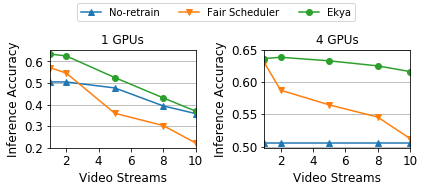

In [136]:
scheds = ['inference_only', 'fair_dumb','thief']
labels = ["No-retrain", "Fair Scheduler", "Ekya"]
nrow = 1; ncol = 2;
factor=1.2
fig, axs = plt.subplots(figsize=[5*factor, 2*factor], nrows=nrow, ncols=ncol)

axs = axs.reshape(-1)
res_counts = [1,4]
for i, res in enumerate(res_counts):
    final_data = mean_acc_data.query('res == {}'.format(res))[scheds].unstack(0)
    ax=final_data.plot(style=styles, label = labels, ax=axs[i], legend=False)
    ax.set_xlabel('Video Streams')
    ax.set_ylabel('Inference Accuracy')
    
    if res == 1:
        y_tick_range = np.arange(0.2,0.65,0.1)
    elif res == 2:
        y_tick_range = np.arange(0.3,0.65,0.1)
    elif res == 4:
        y_tick_range = np.arange(0.5,0.65,0.05)
    elif res == 8:
        y_tick_range = np.arange(0.5,0.65,0.05)
    else:
        raise Exception
    ax.set_yticks(y_tick_range)
    
    x_tick_range = np.arange(2,10.1,2)
    ax.set_xticks(x_tick_range)
    
    handles, _ = ax.get_legend_handles_labels()
    ax.yaxis.grid(True)
    ax.set_title("{} GPUs".format(res))
    
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.12), ncol=3)
#lgd = plt.legend(loc="lower center", bbox_to_anchor=(0,1.02,1,0.2), ncol=2, prop={'size': 'small'})
plt.tight_layout()
plt.savefig(os.path.join(PLOT_PATH, "scalability_cams_fixedGPUs_{}.pdf".format(dataset)), bbox_inches='tight')

# Custom plots

In [65]:
custom_data = {
    0.9: {
        'Ekya': [[1,2,4,8],[1, 2, 5, 9]],
        'Fair Scheduler': [[1,2,4,8],[0, 0, 2, 4]]
    },
    0.75: {
        'Ekya': [[1,2,4,8],[3, 7, 11, 14]],
        'Fair Scheduler': [[1,2,4,8],[1, 2, 3, 7]]
    },
#     0.5: {
#         'Ekya': [[1,2,4,8],[6, 13, 20, 20]],
#         'Fair Scheduler': [[1,2,4,8],[4, 9, 14, 18]]
#     },
}
markers = {
    'Ekya': 'o',
    'Fair Scheduler': 'v'
}
colors = {
    'Ekya': 'C2',
    'Fair Scheduler': 'C1'
}

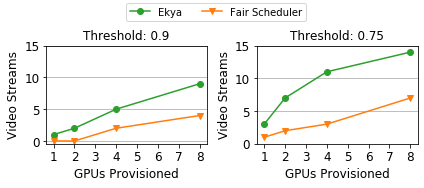

In [72]:
nrow = 1; ncol = 2;
factor = 1.2
fig, axs = plt.subplots(figsize=[5*factor, 2*factor], nrows=nrow, ncols=ncol)

axs = axs.reshape(-1)
for j, (threshold, plotd) in enumerate(custom_data.items()):
    #fig = plt.figure(figsize=[aspect*height, height])
    ax = axs[j]
    for i, (sched,results) in enumerate(plotd.items()):
        ax.plot(results[0], results[1], label=sched, marker=markers[sched], color=colors[sched])
    ax.set_xlabel('GPUs Provisioned')
    ax.set_ylabel('Video Streams')
    ax.set_title("Threshold: {}".format(threshold))
    
    x_tick_range = np.arange(1,9,1)
    ax.set_xticks(x_tick_range)
    
    if j == 0:
        y_tick_range = np.arange(0,16,5)
    elif j == 1:
        y_tick_range = np.arange(0,16,5)
    elif j == 2:
        y_tick_range = np.arange(0,21,5)
    else:
        raise Exception
    ax.set_yticks(y_tick_range)
    
    ax.yaxis.grid(True)
    handles, labels = ax.get_legend_handles_labels()
    
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.1), ncol=3)
#lgd = plt.legend(loc="lower center", bbox_to_anchor=(0,1.02,1,0.2), ncol=2, prop={'size': 'small'})
plt.tight_layout()
plt.savefig(os.path.join(PLOT_PATH, "scalability_GPUs_cams_{}.pdf".format(dataset)), bbox_inches='tight')

# See if multiperiod makes sense

In [149]:
PERIOD=100
USE_ORACLE_INFO = True
d = all_data
d = d[d['use_oracle'] == USE_ORACLE_INFO]
scheds = ['inference_only', 'fair_dumb','thief']
labels = ["No-retrain", "Fair Scheduler", "Ekya"]

In [150]:
d

,time,task_1,task_2,task_3,task_4,task_5,city,res,period,use_oracle,sched
0,0,0.292339,0.322477,0.295353,0.364671,0.298367,aachen,1,100,True,fair_dumb
1,1,0.292339,0.322477,0.295353,0.364671,0.298367,aachen,1,100,True,fair_dumb
2,2,0.292339,0.322477,0.295353,0.364671,0.298367,aachen,1,100,True,fair_dumb
3,3,0.292339,0.322477,0.295353,0.364671,0.298367,aachen,1,100,True,fair_dumb
4,4,0.292339,0.322477,0.295353,0.364671,0.298367,aachen,1,100,True,fair_dumb
5,5,0.292339,0.322477,0.295353,0.364671,0.298367,aachen,1,100,True,fair_dumb
6,6,0.292339,0.322477,0.295353,0.364671,0.298367,aachen,1,100,True,fair_dumb
7,7,0.292339,0.322477,0.295353,0.364671,0.298367,aachen,1,100,True,fair_dumb
8,8,0.292339,0.322477,0.295353,0.364671,0.298367,aachen,1,100,True,fair_dumb
9,9,0.292339,0.322477,0.295353,0.364671,0.298367,aachen,1,100,True,fair_dumb
